# Выбор локации для скважины

Нужно решить, где бурить новую скважину.

Представлены данные о трех регионах. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**  
Данные геологоразведки трёх регионов:  

**id** — уникальный идентификатор скважины;  
**f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы);  
**product** — объём запасов в скважине (тыс. баррелей).  

 

## Загрузка и подготовка данных

Откроем, изучим и подготовим данные.

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")

In [2]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

Напишем функцию, которая будет выводить всю необходимую информацию по конкретному датафрейму.

In [3]:
 def show(df, frame_name):
    name_string = "#   "+ str(frame_name) + "   #"
    len_label = len(name_string)
        
        
    print("#"*len_label)
    print(name_string)
    print("#"*len_label)
    print()
    print(df.info())
    print()
    print(df.describe())
    print()
    print(df.head(5))
    print()
    print('Количество дубликатов:', df.duplicated().sum())
    print()
    print(df.corr())
    print()
    
    
    
    global title
    list = ['f0', 'f1', 'f2', 'product']
    for col in list:
        fig, axs = plt.subplots(ncols=2,figsize=(20, 5))
        sns.set(font_scale=1.10)
        distplot = sns.distplot(df[col],ax=axs[0]).set_title(f'DataFrame №{title}',fontsize=15);
        sns.boxplot(df[col], ax=axs[1]).set_title(f'DataFrame №{title}',fontsize=15);
           
   

### Датафрейм 0

###########
#   DF0   #
###########

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347

      id        f0        f

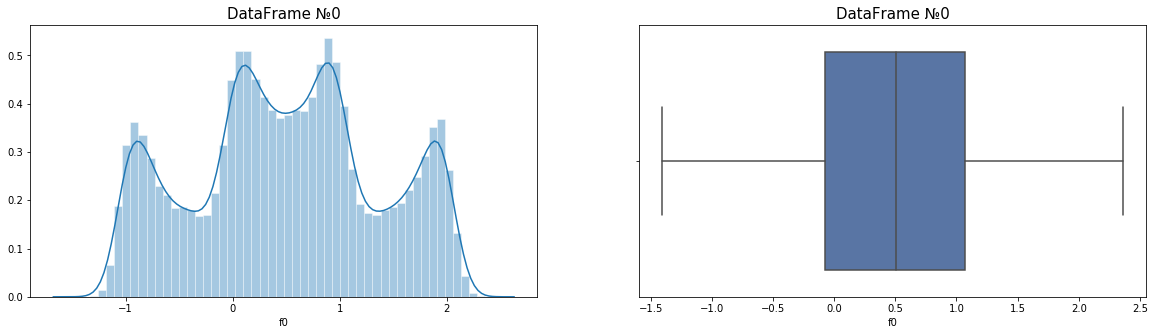

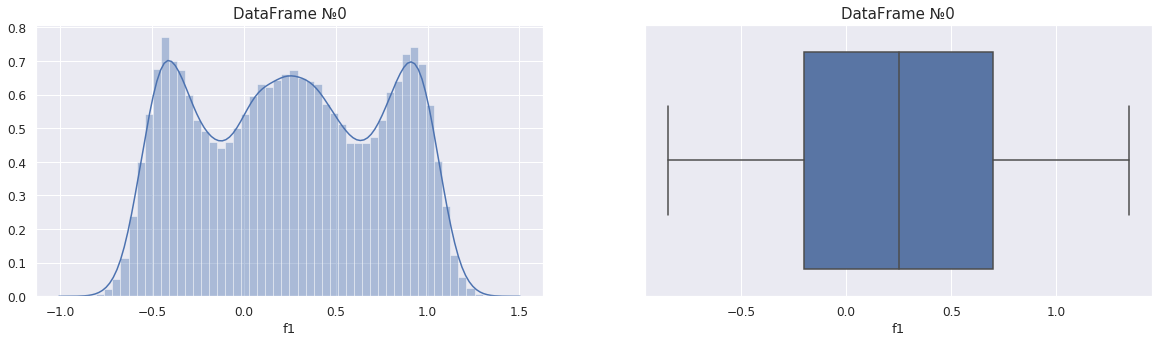

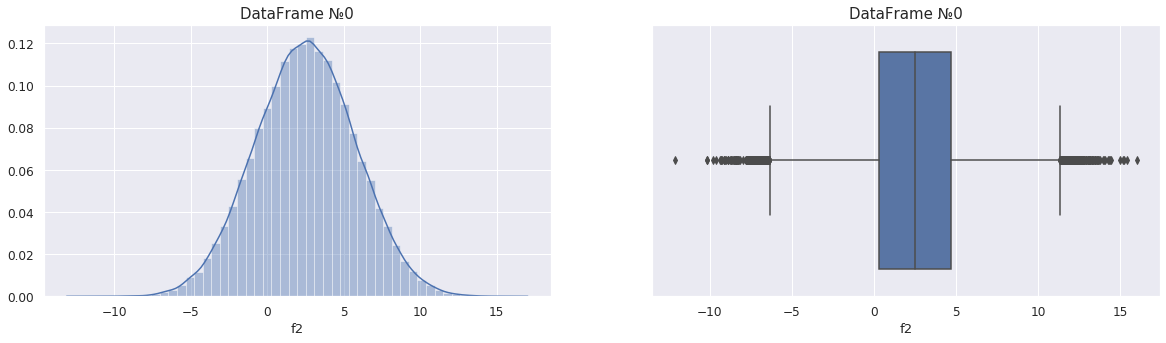

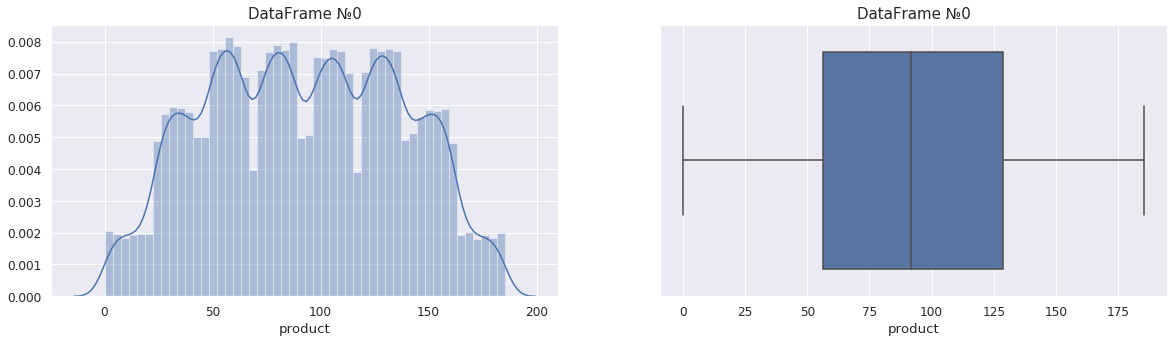

In [4]:
title = '0'

show(df0, 'DF0')

Пропусков нет, дубликатов нет, распределение нормальное (медиана почти равна среднему).  

Признаки **"f0"** и **"f1"** отрицательно коррелируют относительно друг друга, **"f2"** слабо положительно коррелирует с целевым признаком. 

Признак **"f0"** имеет 4 пика. Пики в районе -1, 0, 1 и 2. Медиана 0.5.  
Признак **"f1"** имеет 3 пика. Пики в районе -0.5, 0.25, и 1. Медиана 0.25.  
Признак **"f2"** имеет нормальное распределение с медианой 2.5. Наблюдаются выбросы.  
Столбец **"product"**: 4 основных пика. По предварительному визуальному осмотру данных, можно предположить, что в районе есть множество перспективных скважин.

### Датафрейм 1

###########
#   DF1   #
###########

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063       5.019721     137.945408

      id         f0        

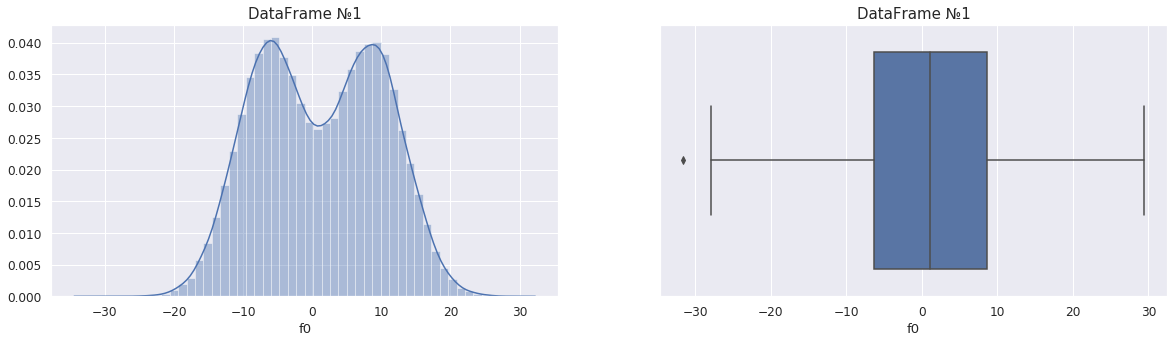

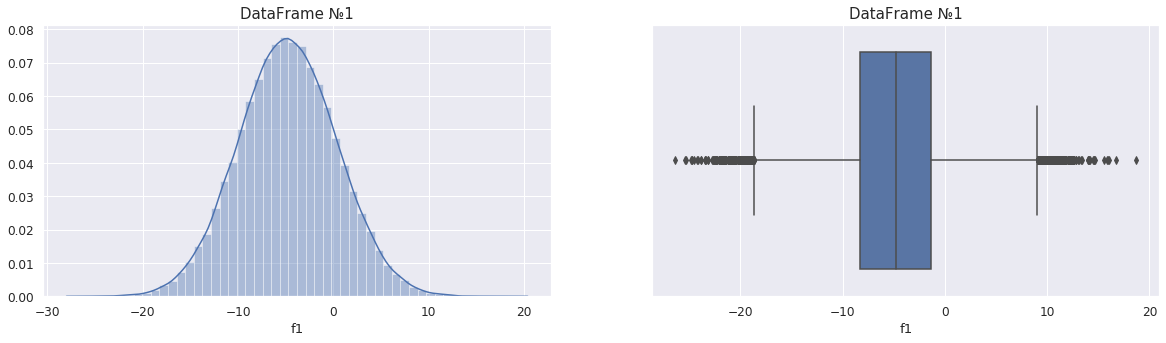

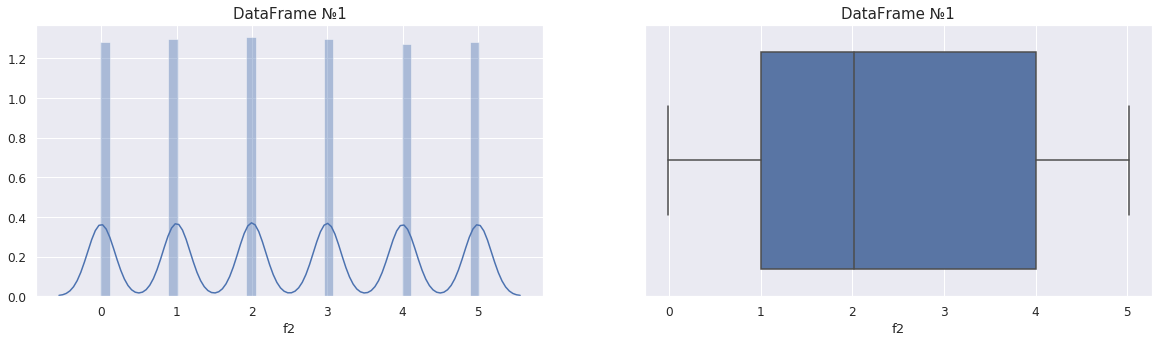

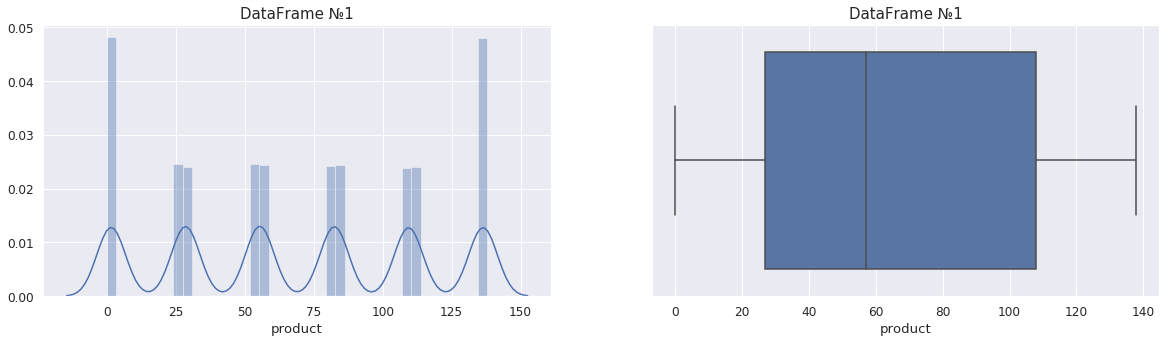

In [5]:
title = '1'

show(df1, 'DF1')

Пропусков нет, дубликатов нет, распределение данных скошено вправо ('f2', 'product').

**"f2"** и **"product"** имеют очень высокую 0.999397 корреляцию.

Признак **"f0"** имеет 2 пика. Пики в районе -10, и 10. Медиана 1. Отрицательные выбросы.  
Признак **"f1"** имеет нормальное распределение с медианой -4.8. Наблюдаются выбросы.  
Признак **"f2"** имеет скос вправо, медиана равна 2. График имеет довольно странный вид, возможно, из-за количества уникальных значений.  
Столбец **'product'**: можно предположить, что в районе сбора данные есть несколько тысяч перспективных скважин с мощностью около 130 тыс. баррелей.

### Датафрейм 2

###########
#   DF2   #
###########

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801      16.739402     190.029838

      id        f0        f

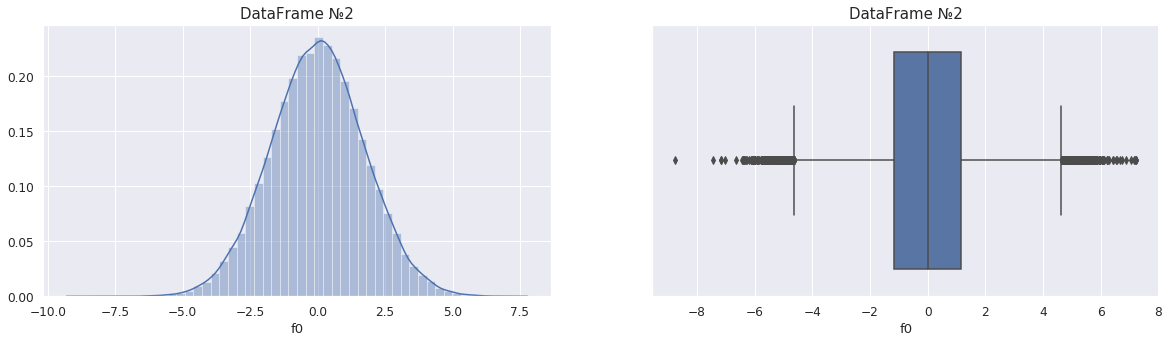

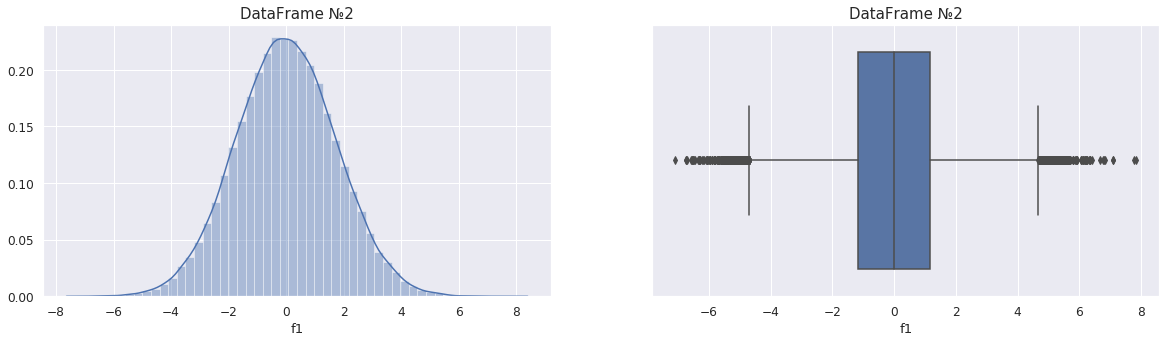

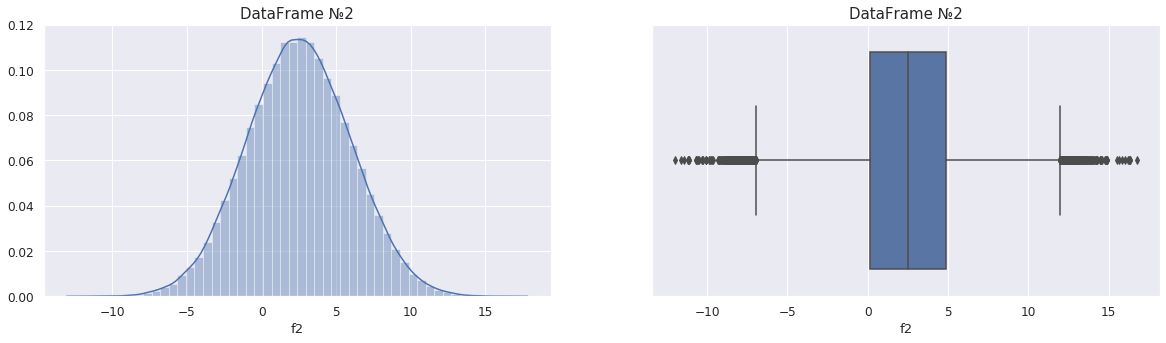

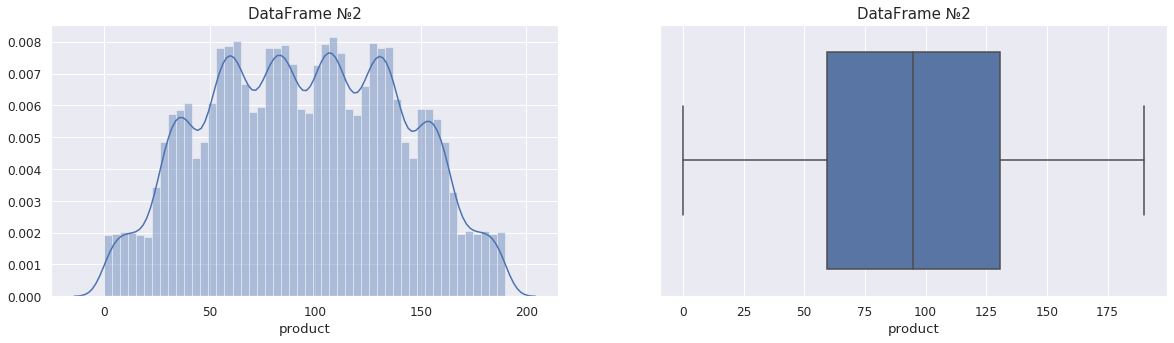

In [6]:
title = '2'

show(df2, 'DF2')

Пропусков нет, дубликатов нет.

**"f2"** и **"product"**: 0.445871 - корреляция ближе к средней.

Признак **"f0"** имеет нормальное распределение с медианой в районе нуля. Наблюдаются выбросы.  
Признак **"f1"** нормальное распределение с медианой около нуля с отрицательной стороны. Наблюдаются выбросы. Графики "f0" и "f1" похожи визуально.  
Признак **"f2"** имеет нормальное распределение с медианой в окресностях 2.5. Выбросы.  
Столбец **'product'**: в районе сбора есть несколько тысяч перспективных скважин с мощностью около 175 тыс. баррелей и более.

###  Исправление данных

В некоторых столбцах есть данные, выходящие за границы. Они будут мешать модели обучаться - необходимо удалить. 

Выпишем необходимые столбцы для обработки в формате - (фрейм, столбец):
- (df0,"f2")
- (df1,"f1")
- (df2,"f0")
- (df2,"f1")
- (df2,"f2")

In [7]:
def remove(frame,column):
    
    q25=np.array(frame[column].quantile(0.25))
    q75=np.array(frame[column].quantile(0.75))
    
    first_part=q25-1.5*(q75-q25)
    second_part=q75+1.5*(q75-q25)
    
    del_index = []
    for index_value, value in zip(frame[column].index,frame[column]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    
    print('Количество строк для удаления: ',len(del_index))
    return del_index

In [8]:
noise_data = [(df0,"f2"),
 (df1,"f1"),
 (df2,"f0"),
 (df2,"f1"),
 (df2,"f2")]

for frame,column in noise_data:
    indexes = remove(frame,column)
    frame.drop(indexes,axis = 0,inplace = True)

Количество строк для удаления:  506
Количество строк для удаления:  636
Количество строк для удаления:  733
Количество строк для удаления:  682
Количество строк для удаления:  582


Необходимо отметить, что удаление возможно, т.к. потери не слишком существенны (около 1% для первых двух выборок, для последней - 2%).

In [9]:
df0 = df0.reset_index(drop = True)
df1 = df1.reset_index(drop = True)
df2 = df2.reset_index(drop = True)

###  Выводы

- Пропуски, дубликаты - отсутствуют
- Типы, названия столбцов - корректны
- Коррелирующие признаки - учтены
- Выбросы - удалены


## Обучение и проверка модели

- Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
- Обучите модель и сделайте предсказания на валидационной выборке.
- Сохраните предсказания и правильные ответы на валидационной выборке.
- Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
- Проанализируйте результаты.

In [7]:
df0_features = df0.drop(['product','id'], axis=1)
df0_target = df0['product']
df1_features = df1.drop(['product','id'], axis=1)
df1_target = df1['product']
df2_features = df2.drop(['product','id'], axis=1)
df2_target = df2['product']    

df0_features_train, df0_features_valid, df0_target_train, df0_target_valid =\
train_test_split(df0_features, df0_target, test_size=0.25)

df1_features_train, df1_features_valid, df1_target_train, df1_target_valid =\
train_test_split(df1_features, df1_target, test_size=0.25)

df2_features_train, df2_features_valid, df2_target_train, df2_target_valid =\
train_test_split(df2_features, df2_target, test_size=0.25)

In [8]:
model = LinearRegression()

In [9]:
model.fit(df0_features_train, df0_target_train)
df0_predicted_valid = model.predict(df0_features_valid)
df0_mse = mean_squared_error(df0_target_valid, df0_predicted_valid)
df0_rmse = df0_mse**0.5
df0_mean = df0_predicted_valid.mean()
print(f'Средний запас предсказанного сырья: {df0_mean}, RMSE = {df0_rmse}')

Средний запас предсказанного сырья: 92.51062374335011, RMSE = 37.69042847015181


In [10]:
model.fit(df1_features_train, df1_target_train)
df1_predicted_valid = model.predict(df1_features_valid)
df1_mse = mean_squared_error(df1_target_valid, df1_predicted_valid)
df1_rmse = df1_mse**0.5
df1_mean = df1_predicted_valid.mean()
print(f'Средний запас предсказанного сырья: {df1_mean}, RMSE = {df1_rmse}')

Средний запас предсказанного сырья: 68.63278960750044, RMSE = 0.8884662992817365


In [11]:
model.fit(df2_features_train, df2_target_train)
df2_predicted_valid = model.predict(df2_features_valid)
df2_mse = mean_squared_error(df2_target_valid, df2_predicted_valid)
df2_rmse = df2_mse**0.5
df2_mean = df2_predicted_valid.mean()
print(f'Средний запас предсказанного сырья: {df2_mean}, RMSE = {df2_rmse}')

Средний запас предсказанного сырья: 95.02325154044289, RMSE = 40.31774320954701


- Нулевой регион:
 По ошибке и по среднему объему регион на втором месте.
 
  
- Первый регион:
 Проигрывает другим регионам по среднему объему запасов, лучший результат по ошибке (чем ближе корень из средней квадратичной ошибки (RMSE) к нулю тем лучше).
 
  
- Второй регион:
 Самый большой средний объем запасов, но по ошибке регион на последнем месте.

## Подготовка к расчёту прибыли

- Все ключевые значения для расчётов сохраните в отдельных переменных.
- Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.
- Напишите выводы по этапу подготовки расчёта прибыли.

In [12]:
# Бюджет на разработку скважин в регионе
regional_budget = 10_000_000_000 
# Доход с одного барреля сырья 
one_barrel_income = 450  
# Доход с каждой единицы продукта 
income_per_unit = 450_000 
# Количество лучших шахт для расчета прибыли
final_max_points = 200 

# Объем добычи для безубыточной разработки
regional_development = regional_budget/income_per_unit
staple_volume = regional_development / final_max_points
round(staple_volume,2)

111.11

Сравним полученный объём сырья со средним запасом в каждом регионе.

In [13]:
means = [92.34026807784673, 68.9461217736548, 94.94583954250197]

def compare(region_volumes):
    for i in range(len(region_volumes)):
        if region_volumes[i] < staple_volume:
            print(f'Средний предсказанный запас сырья в регионе {i} меньше достаточного на {round(staple_volume-region_volumes[i], 2)}')
        else:
            print(f'Средний предсказанный запас сырья в регионе {i+1} больше достаточного на {round(region_volumes[i]-staple_volume, 2)}')

In [14]:
compare(means)

Средний предсказанный запас сырья в регионе 0 меньше достаточного на 18.77
Средний предсказанный запас сырья в регионе 1 меньше достаточного на 42.16
Средний предсказанный запас сырья в регионе 2 меньше достаточного на 16.17


После сравнения средних предсказанных моделю запасов сырья: среднее значение запасов во всех трех регионах меньше необходимого для безубыточной разработки;  
Ближе всего к необходимому количеству предсказанные запасы втрого региона, меньше всего предсказанных запасов в первом.

## Расчёт прибыли и рисков 

In [15]:
# Функция для расчета прибыли по выбранным скважинам и предсказаниям модели
def profit(target, predictions):
    target = pd.Series(target).reset_index(drop=True)
    predictions = pd.Series(predictions).reset_index(drop=True)
    predictions_s = predictions.sort_values(ascending=False)[:final_max_points].index
    selected = target[predictions_s]
    revenue = selected.sum() * income_per_unit - regional_budget
    return round(revenue, 2)

In [16]:
profit(df0_target_valid, df0_predicted_valid)

3114140703.84

In [17]:
profit(df1_target_valid, df1_predicted_valid)

2415086696.68

In [18]:
profit(df2_target_valid, df2_predicted_valid)

2770993179.1

В каждом регионе отобрали по 200 скважин с наибольшей мощностью (по предсказанию модели). Просуммировали  данные. Посчитали прибыль: вычли из всех денег, которые принесут все скважины, бюджет на разработку в данном регионе.   
Предварительно, прибыль от разработки от 2,4 до 3,0 млрд рублей.

## Посчитайте риски и прибыль для каждого региона

In [19]:
def bootstrap(target, probabilities, iterations, sample_size):
    state = np.random.RandomState(12345)
    values = []
    for i in range(iterations):
        target_subsample = target.sample(n=sample_size, random_state=state, replace=True)
        probs_subsample = probabilities[target_subsample.index]
        values.append(profit(target_subsample, probs_subsample))

    values = pd.Series(values)
    mean = values.mean()
    risk = (values < 0).mean()
    confidence_interval = st.t.interval(0.95, len(values)-1, loc=values.mean(), scale=values.sem())
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    quantile_interval = (lower, upper)
    return round(mean,2), confidence_interval, round(risk*100, 2), quantile_interval

In [20]:
df0_mean, df0_interval, df0_risk, df0_quantile = bootstrap(df0_target_valid.reset_index(drop=True), df0_predicted_valid, 1000, 500)
print('Регион DataFrame_0: средняя выручка = ', df0_mean)
print('Регион DataFrame_0: 95 %ый доверительный интервал по стьюденту = ', df0_interval)
print('Регион DataFrame_0: 95 %ый доверительный интервал по квантилям = ', df0_quantile)
print(f'Регион DataFrame_0: Риск убытков: {df0_risk}%')

Регион DataFrame_0: средняя выручка =  417934636.16
Регион DataFrame_0: 95 %ый доверительный интервал по стьюденту =  (401669033.9640714, 434200238.3641486)
Регион DataFrame_0: 95 %ый доверительный интервал по квантилям =  (-123341748.67974998, 945261980.4035)
Регион DataFrame_0: Риск убытков: 5.5%


In [21]:
df1_mean, df1_interval, df1_risk, df1_quantile = bootstrap(df1_target_valid.reset_index(drop=True), df1_predicted_valid, 1000, 500)
print('Регион DataFrame_1: средняя выручка = ', df1_mean)
print('Регион DataFrame_1: 95 %ый доверительный интервал по стьюденту = ', df1_interval)
print('Регион DataFrame_1: 95 %ый доверительный интервал по квантилям = ', df1_quantile)
print(f'Регион DataFrame_1: Риск убытков: {df1_risk}%')

Регион DataFrame_1: средняя выручка =  405126269.78
Регион DataFrame_1: 95 %ый доверительный интервал по стьюденту =  (392080938.39807177, 418171601.1535883)
Регион DataFrame_1: 95 %ый доверительный интервал по квантилям =  (12448646.727750005, 839474733.2382499)
Регион DataFrame_1: Риск убытков: 2.1%


In [22]:
df2_mean, df2_interval, df2_risk, df2_quantile = bootstrap(df2_target_valid.reset_index(drop=True), df2_predicted_valid, 1000, 500)
print('Регион DataFrame_2: средняя выручка = ', df2_mean)
print('Регион DataFrame_2: 95 %ый доверительный интервал по стьюденту = ', df2_interval)
print('Регион DataFrame_2: 95 %ый доверительный интервал по квантилям = ', df2_quantile)
print(f'Регион DataFrame_2: Риск убытков: {df2_risk}%')

Регион DataFrame_2: средняя выручка =  340608699.21
Регион DataFrame_2: 95 %ый доверительный интервал по стьюденту =  (323723570.8293681, 357493827.5812719)
Регион DataFrame_2: 95 %ый доверительный интервал по квантилям =  (-199606670.04, 873034538.76975)
Регион DataFrame_2: Риск убытков: 10.8%


Согласно прогнозам  Bootstrap, наиболее прибыльным будет разработка месторождений в регионе DataFrame_1.  
У этого региона наименьшая вероятность убытков(1.9%). В пределах доверительного интервала 95% добыча остаётся безубыточной, и средняя выручка выше, чем в остальных.

## Вывод

- В начале работы провели подробный анализ данных, удалили часть - выбросы, мешающих обучению модели. Проверка на корреляцию показала в DataFrame_1 очень сильную связь между целевым признаком и признаком "f2".  

- После подготовки данных, была обучена модель Линейной регрессии для каждого датасета. DataFrame_1 показал лучший результат по ошибке, но уступил остальным регионам по среднему объему запасов.  

- Далее была посчитана прибыль по предсказанниям моделей:

  - Прибыль DataFrame_0: 3.2276 млрд.руб.
  - Прибыль DataFrame_1: 2.4150 млрд.руб.
  - Прибыль DataFrame_2: 2.4381 млрд.руб.

- По прибыли лидировала область DataFrame_0, но техника Bootstrap показывает значительные риски убытков: 5%.

- Анализ Bootstrap окончательно дает понять, что регион DataFrame_1, наиболее удачный вариант - при разработке 200 скважин вероятность убытков наименьшая.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [х]  Весь код выполняется без ошибок
- [х]  Ячейки с кодом расположены в порядке исполнения
- [х]  Выполнен шаг 1: данные подготовлены
- [х]  Выполнен шаг 2: модели обучены и проверены
    - [х]  Данные корректно разбиты на обучающую и валидационную выборки
    - [х]  Модели обучены, предсказания сделаны
    - [х]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [х]  На экране напечатаны результаты
    - [х]  Сделаны выводы
- [х]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [х]  Для всех ключевых значений созданы константы Python
    - [х]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [х]  По предыдущему пункту сделаны выводы
    - [х]  Написана функция расчёта прибыли
- [х]  Выполнен шаг 4: посчитаны риски и прибыль
    - [х]  Проведена процедура *Bootstrap*
    - [х]  Все параметры бутстрепа соответствуют условию
    - [х]  Найдены все нужные величины
    - [х]  Предложен регион для разработки месторождения
    - [х]  Выбор региона обоснован